##**Exercise**


Instructor: Dr Mario Rosario Guarracino


---


**Load libraries**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# % cd "/content/drive/My Drive/2020 09 Cambridge course/PyNotebooks/"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import sys
import scipy
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV

# Classifier metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

**Read in the data**

This is a gene expression dataset derived from 224 blood samples of smokers and non-smokers which was used as a training set for the sbv improver systems toxicology computational challenge. More details on the data and challenge here:

- Belcastro, V., Poussin, C., Xiang, Y., Giordano, M., Tripathi, K.P., Boda, A., Balci, A.T., Bilgen, I., Dhanda, S.K., Duan, Z. and Gong, X., 2018. The sbv improver systems toxicology computational challenge: *Identification of human and species-independent blood response markers as predictors of smoking exposure and cessation status*. Computational Toxicology, 5, pp.38-51. https://www.sciencedirect.com/science/article/pii/S2468111317300348#s0220


In [ ]:
gene_exp = pd.read_csv('data/sc1_training_SvNCS.csv')

**Explore the data**

In [ ]:
gene_exp.head()

,A1BG,A2M,NAT1,NAT2,SERPINA3,AADAC,AAMP,AANAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCB7,ABCF1,ABCA4,ABL1,AOC1,ABL2,ABO,ABR,ACAA1,ACACA,ACACB,ACADL,ACADM,ACADS,ACADSB,ACADVL,ACAT1,ACAT2,ASIC2,ASIC1,ACHE,ACLY,ACO1,ACO2,ACOX1,ACP1,ACP2,...,LOC100507600,TRIM52-AS1,LINC00837,LOC100507616,LINC00658,LOC100507630,LINC00968,LOC100507634,LOC100507642,LOC100507654,SRGAP3-AS2,LOC100507670,ERVK3-1,CAHM,LHX4-AS1,ARMCX5-GPRASP2,ZHX1-C8orf76,RTEL1-TNFRSF6B,SEC24B-AS1,ARHGAP19-SLIT1,TPTE2P5,DIO2-AS1,DNM3OS,LOC100630918,LOC100631378,PYCARDOS,LOC100652768,LOC100652770,GS1-24F4.2,LOC100652824,LINC01023,LINC00408,LOC100652911,HP09025,LOC100652931,LOC100652972,LOC100652999,PP12719,gender,class
0,5.396786,4.534597,7.045734,3.662165,3.658115,3.677027,7.067891,4.131286,7.455826,7.357040,8.093526,6.843366,6.236385,8.494758,8.363593,3.761509,6.344239,4.985875,6.507855,5.174546,7.008380,8.597345,7.137747,6.898479,3.693847,7.321361,6.508556,6.365637,8.597267,7.034253,8.096963,4.797635,4.644133,4.397555,7.679794,5.837074,6.548703,8.948575,7.937556,7.296623,...,4.303625,6.487710,3.768323,6.476429,4.120177,4.129062,4.380580,4.102055,6.527217,4.752603,4.414306,5.701708,7.359454,6.852971,7.188598,6.584122,6.237157,6.086693,5.782752,4.171002,6.194569,4.088789,3.578065,5.241386,3.787440,6.046962,7.375876,4.412609,4.277079,4.358922,4.566736,3.049875,4.130656,5.497184,4.331380,4.647192,4.910128,9.131723,M,NCS
1,5.274138,5.165578,7.241612,3.877878,3.621586,3.731513,6.920622,4.326308,7.345178,8.098586,8.690068,6.922907,5.862233,8.370138,8.248511,4.260413,6.126731,4.840430,6.494665,5.271336,7.475615,8.743910,7.193135,6.938905,3.669141,6.463892,6.897445,5.916667,8.651068,6.577034,7.877538,4.507613,4.508902,4.592821,7.966420,6.189850,6.825319,9.360704,7.793026,7.464197,...,4.490715,6.751968,3.633694,5.501008,4.032514,4.965708,4.225420,4.141163,6.380679,5.076968,4.621396,5.743249,7.419496,6.707263,6.997609,6.714174,6.219734,6.661503,5.114774,4.105197,5.548286,3.648757,3.605890,5.190899,3.892637,5.803619,7.520102,4.433905,4.064756,4.203797,4.157252,3.034889,4.142024,5.565870,4.296273,4.847122,4.912810,8.133504,M,NCS
2,5.505105,4.265590,6.488771,3.890642,3.891133,4.218688,6.924482,4.081022,7.214808,7.712981,8.662266,7.075216,5.810172,7.680200,8.280960,4.112947,6.440727,4.512362,6.524023,5.372002,7.334602,9.153592,7.116432,6.915343,3.751108,6.378146,6.739158,5.475178,8.892831,6.295709,7.799453,4.733254,4.390067,4.239343,7.976253,5.494855,6.731518,9.541321,7.664552,7.613092,...,4.208392,6.612687,3.688937,4.747611,4.443392,4.627549,4.565839,4.128507,6.370682,4.804655,4.731427,5.929585,7.380631,7.264202,7.772130,6.048288,6.077844,6.512043,5.502287,4.012791,5.405660,3.841488,3.685685,5.602754,3.928082,5.540763,7.265504,5.319210,4.336140,4.708609,4.717228,3.014206,4.095600,5.257701,4.107110,4.491645,4.707239,9.434935,M,NCS
3,5.893543,4.435600,6.030749,3.926663,4.009032,3.953535,7.579075,4.225339,7.598168,6.916718,6.801154,7.041335,6.588870,8.026060,8.815053,4.220695,7.225089,5.467924,6.561965,5.427976,7.314560,8.330773,7.545581,7.041995,3.728504,6.538159,6.776494,5.729209,9.204919,6.718022,7.646036,4.706284,4.598260,4.615578,7.724884,6.093365,7.440295,8.386999,7.824700,7.869216,...,4.265829,7.213363,3.621859,5.136131,4.288509,4.555918,4.105852,4.285279,6.105416,4.664663,4.361053,6.069870,6.787665,6.343497,6.744011,6.478102,6.113765,6.276345,5.394135,3.817665,5.487165,4.046930,3.656314,5.716655,3.867597,6.310011,7.758997,4.143693,4.266086,4.346092,4.709703,3.166516,4.207766,5.592870,4.131711,5.064401,4.984617,8.577083,M,S
4,5.433877,4.413705,6.496719,4.135051,3.834056,4.258759,7.254900,3.950482,7.729225,7.844790,8.505421,6.962940,6.437469,7.961984,8.589982,4.130635,6.542900,6.573997,6.682166,4.822055,7.214090,8.766109,7.354027,7.252546,3.728389,6.520903,6.566483,5.920777,9.135152,6.591644,7.997270,4.632093,4.533904,4.398867,8.342380,5.952412,7.153874,9.018563,7.641568,7.940201,...,4.662616,6.845223,3.674458,5.160403,4.032333,4.707187,4.036847,4.601523,6.639494,4.949571,4.383532,5.724883

In [ ]:
print(gene_exp.shape)
gene_exp.describe
# This shows that the last two columns: gender and class are not numeric.

(224, 18606)


<bound method NDFrame.describe of          A1BG       A2M      NAT1  ...   PP12719  gender  class
0    5.396786  4.534597  7.045734  ...  9.131723       M    NCS
1    5.274138  5.165578  7.241612  ...  8.133504       M    NCS
2    5.505105  4.265590  6.488771  ...  9.434935       M    NCS
3    5.893543  4.435600  6.030749  ...  8.577083       M      S
4    5.433877  4.413705  6.496719  ...  9.252910       M      S
..        ...       ...       ...  ...       ...     ...    ...
219  5.671112  4.987621  5.868688  ...  8.294454       F    NCS
220  5.488326  5.088246  6.515467  ...  8.339227       M    NCS
221  6.007845  4.617715  6.488835  ...  9.313390       M      S
222  5.957094  4.596013  6.119879  ...  9.015486       F      S
223  5.380116  4.764084  7.117982  ...  8.439965       F      S

[224 rows x 18606 columns]>

In [ ]:
gene_exp = gene_exp.drop('gender', axis=1) # drop gender

In [ ]:
X = gene_exp.iloc[:, :-1]
# class labels
y = gene_exp.iloc[:, -1]
print(y.dtype)
print(X.shape)
print(y.shape)

labels, counts = np.unique(y, return_counts=True)
print('labels', labels)
print('counts', counts)
print(y)
y = y.replace(labels, [0, 1]).array

print(y)


object
(224, 18604)
(224,)
labels ['NCS' 'S']
counts [115 109]
0      NCS
1      NCS
2      NCS
3        S
4        S
      ... 
219    NCS
220    NCS
221      S
222      S
223      S
Name: class, Length: 224, dtype: object
<PandasArray>
[0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
 ...
 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]
Length: 224, dtype: int64


In [ ]:
print(gene_exp.isnull().sum().sum())
print(gene_exp.isna().sum().sum())

0
0


Explained variance ratio (first two components): 
 [0.21445145 0.07219982]


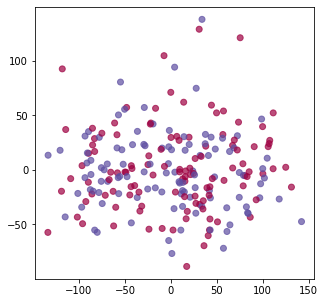

In [ ]:
# Divide the dataframe into attributes in X and disease diagnosis labels stored in y
X = gene_exp.iloc[:, :-1]
X.shape, y.shape

# scale X
scaler = StandardScaler()
# rows are patient samples and columns are genes so we will transpose it for 
X_scaled = scaler.fit_transform(X)

# PCA on scaled data
pca_sc = PCA(n_components=2)
X_pca_scaled = pca_sc.fit_transform(X_scaled)

plt.figure(figsize=(5, 5))
plt.scatter(X_pca_scaled[:, 0], X_pca_scaled[:, 1], c=y, cmap="Spectral", alpha=0.7)

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): \n', '%s'
      % str(pca_sc.explained_variance_ratio_))

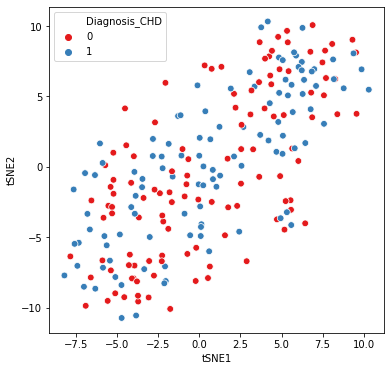

In [ ]:
# tSNE with 2 components
x_tsne = TSNE(n_components=2, random_state=1, perplexity=30).fit_transform(X_scaled)
x_tsne.shape

# store tsne output in a dataframe
df_for_tsne = pd.DataFrame({'tSNE1': x_tsne[:, 0], 'tSNE2': x_tsne[:, 1],
              'Diagnosis_CHD': y})

# seaborn for scatterplot
plt.figure(figsize=(6, 6))
sns.scatterplot(x="tSNE1", y="tSNE2",
			  hue='Diagnosis_CHD',
			  legend='full',
				palette =sns.color_palette("Set1", n_colors=2), s=45,
			  data=df_for_tsne)

### **RFE (Recursive feature elimination)**




In [ ]:
X = gene_exp.iloc[:, :-1].values

#Scaler
scaler = StandardScaler()
# classifier
model = SVC(kernel='linear', random_state=1)
# for RFE
estimator_for_rfe = SVC(kernel='linear', C=1, gamma= 0.01, random_state=1)
rfe = RFE(estimator_for_rfe, n_features_to_select=60, step=6000)

# RFECV for rfe with cross-validation 
# rfe = RFECV(estimator_for_rfe, min_features_to_select=60, step=6000, cv=2)

# crossvalidator
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
# baseline accuracy before RFE
model_run_bas = Pipeline([('scaler', scaler), ('SVM', model)])
scores_baseline = cross_val_score(model_run_bas, X, y, scoring='accuracy', cv=cv)
scores_baseline.mean()
print("Accuracy before rfe: ", scores_baseline.mean().round(2), u"\u00B1", scores_baseline.std().round(2))

Accuracy before rfe:  0.89 ± 0.05


In [ ]:
# RFE
model_run_rfe = Pipeline([('scaler', scaler), ('RFE', rfe), ('SVM', model)])
scores_rfe = cross_val_score(model_run_rfe, X, y, scoring='accuracy', cv=cv)

print("Accuracy Top60 rfe: ", scores_rfe.mean().round(2), u"\u00B1", scores_rfe.std().round(2))

Accuracy Top60 rfe:  0.92 ± 0.05


**Load the Top 60 gene signature list identified in the sbv improver systems toxicology computational challenge** (Belcastro et al.)



In [ ]:
genes_sbvtop60 = pd.read_csv('data/sbvImprover_SvNCS_top60.csv')
X = gene_exp[genes_sbvtop60.columns].values

model_run_top_genes = Pipeline([('scaler', scaler), ('SVM', model)])
scores_best = cross_val_score(model_run_top_genes, X, y, scoring='accuracy', cv=cv)
print("Accuracy Top60 sbv: ", scores_best.mean().round(2), u"\u00B1", scores_best.std())

Accuracy Top60 sbv:  1.0 ± 0.0


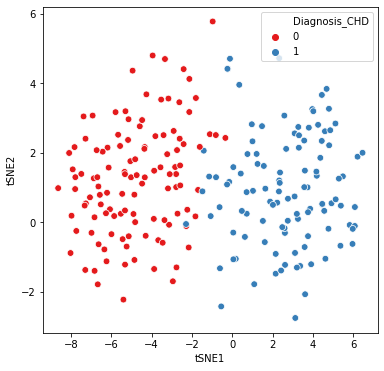

In [ ]:
# tSNE with 2 components and perplexity parameter set at 30
x_tsne = TSNE(n_components=2, random_state=1, perplexity=50).fit_transform(X)

# store tsne output in a dataframe
df_for_tsne = pd.DataFrame({'tSNE1': x_tsne[:, 0], 'tSNE2': x_tsne[:, 1],
              'Diagnosis_CHD': y})

# seaborn for scatterplot
plt.figure(figsize=(6, 6))
sns.scatterplot(x="tSNE1", y="tSNE2",
			  hue='Diagnosis_CHD',
			  legend='full',
				palette =sns.color_palette("Set1", n_colors=2), s=45,
			  data=df_for_tsne)



---

